In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json

import anamic

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from skimage.exposure import rescale_intensity

import tifffile
import read_roi
import tqdm
from tkinter import filedialog
from scipy import ndimage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
## INPUT

pixel_size = 107  # nm

dt = 505  # ms

n = 1 #Frames to average

In [4]:
def open_roi_line(path):
    roi_data = read_roi.read_roi_zip(path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x1'],'x2': roi_data[key]['x2'],'y1': roi_data[key]['y1'],'y2': roi_data[key]['y2']}, ignore_index=True)
    return roi_df

In [69]:
# Open the image and its starting points for fitting
fname = filedialog.askopenfilename()
data_dir = Path(fname).parents[0]

[14.33333302 39.66666794] [18.5        18.33333397]


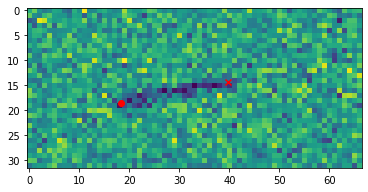

In [71]:
# Open the image
image = tifffile.imread(fname)


# Average every n frames to increase SNR.
image = np.array([image[i::n] for i in range(n)]).sum(axis=0) / n
image = rescale_intensity(image, out_range='uint16').astype('uint16')

# Load lines
roi = open_roi_line(data_dir/('kymolines.zip'))

# Get microtubule tip coordinates
tip_start = np.array([roi['y2'], roi['x2']])
tip_end = np.array([roi['y1'], roi['x1']])
tip_start[1]
    
tip_start = np.transpose(tip_start)[0]
tip_end = np.transpose(tip_end)[0]
print(tip_start,tip_end)
new_dt = dt * n

frame = image[0]
plt.imshow(frame)
plt.scatter(tip_start[1], tip_start[0], color = 'red', marker = 'x')
plt.scatter(tip_end[1], tip_end[0], color = 'red', marker = 'o')

## Single Image Fit (to find optimal parameters)

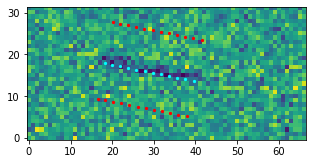

In [72]:
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 2  # pixel
args['get_thick_line_args']['line_thickness'] = 2000 / pixel_size  # pixel
args['get_thick_line_args']['width_spacing'] = 1  # pixel

lines = anamic.fitter.get_thick_line(tip_start, tip_end, **args['get_thick_line_args'])

# Check the new points.
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(frame, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(lines[1, 0], lines[0, 0], color='red', s=20, marker=".")
ax.scatter(lines[1, -1], lines[0, -1], color='red', s=20, marker=".")


middle_index = int(lines.shape[1] / 2)
ax.scatter(lines[1, middle_index], lines[0, middle_index], color='cyan', s=20, marker=".")

TypeError: Invalid shape (399, 32, 67) for image data

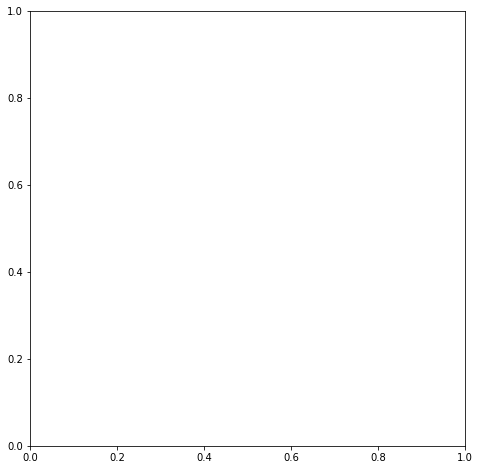

In [73]:
args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 0.5  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 1
args['perpendicular_line_fit_args']['continuous_discard'] = False

fitted_line = anamic.fitter.perpendicular_line_fit(lines, image[0],
                                                   **args['perpendicular_line_fit_args'])

# Now we fit the best line from those points
a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
new_point1 = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
new_point2 = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])

# This the new line defining the microtubule
new_line = np.array([new_point1, new_point2])

# Check the fitted points
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

initial_line = np.array([tip_start, tip_end])

ax.scatter(fitted_line[:, 1], fitted_line[:, 0], color='cyan', s=100, marker=".")
ax.scatter(new_line[:, 1], new_line[:, 0], color='red', s=100, marker="x")
ax.scatter(initial_line[:, 1], initial_line[:, 0], color='yellow', s=100, marker="x")

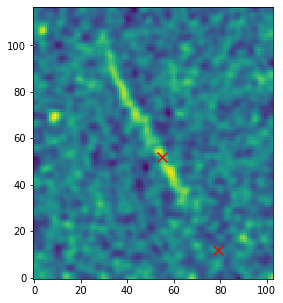

In [104]:
# Now we fit the microtubule using a line profile with a defined thickness.

args['offset_start'] = 3000 / pixel_size  # pixel
args['offset_end'] = 2000 / pixel_size  # pixel

# Calculate the vector of the line and its norm
vec = new_point2 - new_point1

# Get the coordinates of the points we'll use
# to for line fitting.
start_point = anamic.geometry.get_point_from_vector(-vec, new_point2, args['offset_start'])
end_point = anamic.geometry.get_point_from_vector(vec, new_point2, args['offset_end'])
line_fit_tips = np.array([start_point, end_point])

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(line_fit_tips[:, 1], line_fit_tips[:, 0], color='red', s=100, marker="x")

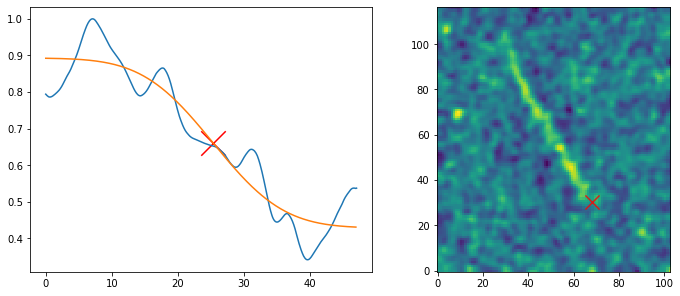

In [105]:
args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 200 / pixel_size  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

x_profile, y_profile, fit_result, fit_func = anamic.fitter.tip_line_fit(line_fit_tips[0],
                                                                        line_fit_tips[1],
                                                                        image,
                                                                        **args['tip_fit_args'])
fit_values = fit_result.values

mu = fit_values['mu']
tip_position = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)

x = np.arange(x_profile[0], x_profile[-1], 0.1)
y_fitted = fit_func(x, **fit_values)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), constrained_layout=True)
ax1.plot(x_profile, y_profile, label='data')
ax1.plot(x, y_fitted, label='fit')
ax1.scatter(mu, fit_func(mu, **fit_values), color='red', s=600, marker='x')

ax2.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax2.set_aspect('equal')
ax2.scatter(tip_position[1], tip_position[0], color='red', s=200, marker="x", alpha=0.8)

## Batch Fit (all timepoints)

In [111]:
# IMPORTANT: take into account the number of averaged frames.
frame_start = 0
frame_end = 200
# frame_start = 730
# frame_end = 740

args = {}
args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 2  # pixel
args['get_thick_line_args']['line_thickness'] = 2000 / pixel_size  # pixel
args['get_thick_line_args']['width_spacing'] = 1  # pixel
args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 1
args['perpendicular_line_fit_args']['continuous_discard'] = False
args['offset_start'] = 3000 / pixel_size  # pixel
args['offset_end'] = 2000 / pixel_size  # pixel
args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 200 / pixel_size  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

data = []

current_point = new_point2

tip_position = tip_end
tip_position_minusoff = tip_start

x_profiles = []
y_profiles = []

for i, frame in enumerate(tqdm.trange(frame_start, frame_end)):
    
    print(frame)
    
    image = stack[frame]

    lines = anamic.fitter.get_thick_line(tip_position_minusoff, tip_position, **args['get_thick_line_args'])

    fitted_line = anamic.fitter.perpendicular_line_fit(lines, image,
                                                       **args['perpendicular_line_fit_args'])

    # Now we fit the best line from those points
    a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
    new_point1 = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
    new_point2 = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])
    
#     ####################
#     fig, ax = plt.subplots(figsize=(5, 5))

#     ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
#     ax.set_aspect('equal')

#     #ax.scatter(lines[1, 0], lines[0, 0], color='red', s=20, marker=".")
#     #ax.scatter(lines[1, -1], lines[0, -1], color='red', s=20, marker=".")

#     middle_index = int(lines.shape[1] / 2)
#     ax.scatter(lines[1, middle_index], lines[0, middle_index], color='orange', s=20, marker=".")
#     plt.show()
#     ####################

    # This the new line defining the microtubule
    new_line = np.array([new_point1, new_point2])

    # Calculate the vector of the line and its norm
    vec = new_point2 - new_point1

    start_point = anamic.geometry.get_point_from_vector(-vec, current_point, args['offset_start'])
    end_point = anamic.geometry.get_point_from_vector(vec, current_point, args['offset_end'])
    line_fit_tips = np.array([start_point, end_point])

    x_profile, y_profile, fit_result, fit_func = anamic.fitter.tip_line_fit(line_fit_tips[0],
                                                                            line_fit_tips[1],
                                                                            image,
                                                                            **args['tip_fit_args'])
    fit_values = fit_result.values

    mu = fit_values['mu']
    sigma = fit_values['sigma']
    mt = fit_values['mt']
    bg = fit_values['bg']
    
    #print(mu*pixel_size/1000)
    
    tip_position = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)
  
    datum = {}
    datum['x'] = tip_position[0]
    datum['y'] = tip_position[1]
    datum['index'] = i
    datum['frame'] = frame
    datum['time'] = i * new_dt
    datum['mu'] = mu
    datum['sigma'] = sigma
    datum['mt'] = mt
    datum['bg'] = bg
    data.append(datum)
    
    x_profiles.append(x_profile)
    y_profiles.append(y_profile)
    
    
    current_point = [tip_position[0],tip_position[1]]
    
    
data = pd.DataFrame(data)
data.to_csv(fname.with_suffix('.csv'), index=False)





  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

0






  0%|▍                                                                                 | 1/200 [00:03<12:02,  3.63s/it]

1






  1%|▊                                                                                 | 2/200 [00:04<09:31,  2.89s/it]

2






  2%|█▏                                                                                | 3/200 [00:06<07:56,  2.42s/it]

3






  2%|█▋                                                                                | 4/200 [00:07<06:37,  2.03s/it]

4






  2%|██                                                                                | 5/200 [00:08<05:45,  1.77s/it]

5






  3%|██▍                                                                               | 6/200 [00:09<05:05,  1.58s/it]

6






  4%|██▊                                                                               | 7/200 [00:10<04:51,  1.51s/it]

7






  4%|███▎                                                                              | 8/200 [00:12<05:25,  1.69s/it]

8






  4%|███▋                                                                              | 9/200 [00:14<05:03,  1.59s/it]

9






  5%|████                                                                             | 10/200 [00:15<04:49,  1.53s/it]

10






  6%|████▍                                                                            | 11/200 [00:16<04:33,  1.45s/it]

11






  6%|████▊                                                                            | 12/200 [00:18<04:19,  1.38s/it]

12






  6%|█████▎                                                                           | 13/200 [00:19<04:07,  1.32s/it]

13






  7%|█████▋                                                                           | 14/200 [00:20<04:03,  1.31s/it]

14






  8%|██████                                                                           | 15/200 [00:21<04:02,  1.31s/it]

15






  8%|██████▍                                                                          | 16/200 [00:23<04:36,  1.50s/it]

16






  8%|██████▉                                                                          | 17/200 [00:25<04:48,  1.58s/it]

17






  9%|███████▎                                                                         | 18/200 [00:27<04:48,  1.59s/it]

18






 10%|███████▋                                                                         | 19/200 [00:28<04:29,  1.49s/it]

19






 10%|████████                                                                         | 20/200 [00:29<04:11,  1.40s/it]

20






 10%|████████▌                                                                        | 21/200 [00:31<04:05,  1.37s/it]

21






 11%|████████▉                                                                        | 22/200 [00:32<04:02,  1.36s/it]

22






 12%|█████████▎                                                                       | 23/200 [00:33<04:07,  1.40s/it]

23






 12%|█████████▋                                                                       | 24/200 [00:35<04:02,  1.38s/it]

24






 12%|██████████▏                                                                      | 25/200 [00:36<04:06,  1.41s/it]

25






 13%|██████████▌                                                                      | 26/200 [00:38<04:23,  1.51s/it]

26






 14%|██████████▉                                                                      | 27/200 [00:39<04:08,  1.44s/it]

27






 14%|███████████▎                                                                     | 28/200 [00:41<04:10,  1.46s/it]

28






 14%|███████████▋                                                                     | 29/200 [00:42<04:10,  1.47s/it]

29






 15%|████████████▏                                                                    | 30/200 [00:44<04:08,  1.46s/it]

30






 16%|████████████▌                                                                    | 31/200 [00:45<04:19,  1.54s/it]

31






 16%|████████████▉                                                                    | 32/200 [00:47<04:12,  1.50s/it]

32






 16%|█████████████▎                                                                   | 33/200 [00:48<03:47,  1.37s/it]

33






 17%|█████████████▊                                                                   | 34/200 [00:49<03:55,  1.42s/it]

34






 18%|██████████████▏                                                                  | 35/200 [00:52<04:35,  1.67s/it]

35






 18%|██████████████▌                                                                  | 36/200 [00:53<04:24,  1.62s/it]

36






 18%|██████████████▉                                                                  | 37/200 [00:55<04:29,  1.66s/it]

37






 19%|███████████████▍                                                                 | 38/200 [00:56<04:26,  1.65s/it]

38






 20%|███████████████▊                                                                 | 39/200 [00:58<04:16,  1.59s/it]

39






 20%|████████████████▏                                                                | 40/200 [00:59<03:56,  1.48s/it]

40






 20%|████████████████▌                                                                | 41/200 [01:00<03:39,  1.38s/it]

41






 21%|█████████████████                                                                | 42/200 [01:02<03:49,  1.45s/it]

42






 22%|█████████████████▍                                                               | 43/200 [01:03<03:43,  1.42s/it]

43






 22%|█████████████████▊                                                               | 44/200 [01:05<04:17,  1.65s/it]

44






 22%|██████████████████▏                                                              | 45/200 [01:07<04:04,  1.58s/it]

45






 23%|██████████████████▋                                                              | 46/200 [01:08<03:45,  1.46s/it]

46






 24%|███████████████████                                                              | 47/200 [01:12<05:25,  2.13s/it]

47






 24%|███████████████████▍                                                             | 48/200 [01:13<04:54,  1.94s/it]

48






 24%|███████████████████▊                                                             | 49/200 [01:15<04:26,  1.77s/it]

49






 25%|████████████████████▎                                                            | 50/200 [01:16<04:09,  1.66s/it]

50






 26%|████████████████████▋                                                            | 51/200 [01:17<03:48,  1.53s/it]

51






 26%|█████████████████████                                                            | 52/200 [01:18<03:32,  1.44s/it]

52






 26%|█████████████████████▍                                                           | 53/200 [01:20<03:38,  1.49s/it]

53






 27%|█████████████████████▊                                                           | 54/200 [01:22<03:34,  1.47s/it]

54






 28%|██████████████████████▎                                                          | 55/200 [01:23<03:27,  1.43s/it]

55






 28%|██████████████████████▋                                                          | 56/200 [01:25<03:49,  1.59s/it]

56






 28%|███████████████████████                                                          | 57/200 [01:27<03:59,  1.67s/it]

57






 29%|███████████████████████▍                                                         | 58/200 [01:28<03:46,  1.59s/it]

58






 30%|███████████████████████▉                                                         | 59/200 [01:29<03:31,  1.50s/it]

59






 30%|████████████████████████▎                                                        | 60/200 [01:31<03:23,  1.45s/it]

60






 30%|████████████████████████▋                                                        | 61/200 [01:32<03:19,  1.43s/it]

61






 31%|█████████████████████████                                                        | 62/200 [01:33<03:16,  1.42s/it]

62






 32%|█████████████████████████▌                                                       | 63/200 [01:35<03:12,  1.40s/it]

63






 32%|█████████████████████████▉                                                       | 64/200 [01:36<03:06,  1.37s/it]

64






 32%|██████████████████████████▎                                                      | 65/200 [01:37<03:03,  1.36s/it]

65






 33%|██████████████████████████▋                                                      | 66/200 [01:39<03:08,  1.41s/it]

66






 34%|███████████████████████████▏                                                     | 67/200 [01:40<03:09,  1.43s/it]

67






 34%|███████████████████████████▌                                                     | 68/200 [01:42<03:06,  1.41s/it]

68






 34%|███████████████████████████▉                                                     | 69/200 [01:43<03:05,  1.41s/it]

69






 35%|████████████████████████████▎                                                    | 70/200 [01:45<03:08,  1.45s/it]

70






 36%|████████████████████████████▊                                                    | 71/200 [01:46<03:02,  1.42s/it]

71






 36%|█████████████████████████████▏                                                   | 72/200 [01:48<03:02,  1.42s/it]

72






 36%|█████████████████████████████▌                                                   | 73/200 [01:49<02:56,  1.39s/it]

73






 37%|█████████████████████████████▉                                                   | 74/200 [01:51<03:09,  1.50s/it]

74






 38%|██████████████████████████████▍                                                  | 75/200 [01:52<03:06,  1.50s/it]

75






 38%|██████████████████████████████▊                                                  | 76/200 [01:53<02:55,  1.42s/it]

76






 38%|███████████████████████████████▏                                                 | 77/200 [01:55<03:00,  1.47s/it]

77






 39%|███████████████████████████████▌                                                 | 78/200 [01:56<02:59,  1.47s/it]

78






 40%|███████████████████████████████▉                                                 | 79/200 [01:58<02:46,  1.37s/it]

79






 40%|████████████████████████████████▍                                                | 80/200 [01:59<02:41,  1.35s/it]

80






 40%|████████████████████████████████▊                                                | 81/200 [02:00<02:35,  1.30s/it]

81






 41%|█████████████████████████████████▏                                               | 82/200 [02:02<02:59,  1.52s/it]

82






 42%|█████████████████████████████████▌                                               | 83/200 [02:03<02:45,  1.41s/it]

83






 42%|██████████████████████████████████                                               | 84/200 [02:04<02:36,  1.35s/it]

84






 42%|██████████████████████████████████▍                                              | 85/200 [02:06<02:36,  1.36s/it]

85






 43%|██████████████████████████████████▊                                              | 86/200 [02:07<02:33,  1.35s/it]

86






 44%|███████████████████████████████████▏                                             | 87/200 [02:08<02:30,  1.33s/it]

87






 44%|███████████████████████████████████▋                                             | 88/200 [02:10<02:33,  1.37s/it]

88






 44%|████████████████████████████████████                                             | 89/200 [02:11<02:25,  1.31s/it]

89






 45%|████████████████████████████████████▍                                            | 90/200 [02:12<02:27,  1.34s/it]

90






 46%|████████████████████████████████████▊                                            | 91/200 [02:14<02:26,  1.34s/it]

91






 46%|█████████████████████████████████████▎                                           | 92/200 [02:15<02:20,  1.30s/it]

92






 46%|█████████████████████████████████████▋                                           | 93/200 [02:17<02:25,  1.36s/it]

93






 47%|██████████████████████████████████████                                           | 94/200 [02:18<02:33,  1.45s/it]

94






 48%|██████████████████████████████████████▍                                          | 95/200 [02:19<02:25,  1.39s/it]

95






 48%|██████████████████████████████████████▉                                          | 96/200 [02:21<02:28,  1.43s/it]

96






 48%|███████████████████████████████████████▎                                         | 97/200 [02:22<02:25,  1.41s/it]

97






 49%|███████████████████████████████████████▋                                         | 98/200 [02:24<02:36,  1.53s/it]

98






 50%|████████████████████████████████████████                                         | 99/200 [02:26<02:44,  1.63s/it]

99






 50%|████████████████████████████████████████                                        | 100/200 [02:27<02:33,  1.53s/it]

100






 50%|████████████████████████████████████████▍                                       | 101/200 [02:29<02:28,  1.50s/it]

101






 51%|████████████████████████████████████████▊                                       | 102/200 [02:30<02:10,  1.34s/it]

102






 52%|█████████████████████████████████████████▏                                      | 103/200 [02:31<02:18,  1.43s/it]

103






 52%|█████████████████████████████████████████▌                                      | 104/200 [02:33<02:12,  1.38s/it]

104






 52%|██████████████████████████████████████████                                      | 105/200 [02:34<02:05,  1.32s/it]

105






 53%|██████████████████████████████████████████▍                                     | 106/200 [02:35<02:15,  1.44s/it]

106






 54%|██████████████████████████████████████████▊                                     | 107/200 [02:37<02:09,  1.39s/it]

107






 54%|███████████████████████████████████████████▏                                    | 108/200 [02:38<02:03,  1.34s/it]

108






 55%|███████████████████████████████████████████▌                                    | 109/200 [02:39<02:03,  1.36s/it]

109






 55%|████████████████████████████████████████████                                    | 110/200 [02:41<02:02,  1.36s/it]

110






 56%|████████████████████████████████████████████▍                                   | 111/200 [02:42<02:05,  1.41s/it]

111






 56%|████████████████████████████████████████████▊                                   | 112/200 [02:44<02:10,  1.48s/it]

112






 56%|█████████████████████████████████████████████▏                                  | 113/200 [02:46<02:11,  1.51s/it]

113






 57%|█████████████████████████████████████████████▌                                  | 114/200 [02:47<02:02,  1.42s/it]

114






 57%|██████████████████████████████████████████████                                  | 115/200 [02:48<01:58,  1.40s/it]

115






 58%|██████████████████████████████████████████████▍                                 | 116/200 [02:49<01:54,  1.37s/it]

116






 58%|██████████████████████████████████████████████▊                                 | 117/200 [02:51<02:00,  1.45s/it]

117






 59%|███████████████████████████████████████████████▏                                | 118/200 [02:52<01:55,  1.41s/it]

118






 60%|███████████████████████████████████████████████▌                                | 119/200 [02:54<02:03,  1.52s/it]

119






 60%|████████████████████████████████████████████████                                | 120/200 [02:56<02:09,  1.62s/it]

120






 60%|████████████████████████████████████████████████▍                               | 121/200 [02:57<01:56,  1.47s/it]

121






 61%|████████████████████████████████████████████████▊                               | 122/200 [02:58<01:48,  1.39s/it]

122






 62%|█████████████████████████████████████████████████▏                              | 123/200 [03:00<01:48,  1.41s/it]

123






 62%|█████████████████████████████████████████████████▌                              | 124/200 [03:01<01:42,  1.35s/it]

124






 62%|██████████████████████████████████████████████████                              | 125/200 [03:02<01:42,  1.37s/it]

125






 63%|██████████████████████████████████████████████████▍                             | 126/200 [03:04<01:40,  1.36s/it]

126






 64%|██████████████████████████████████████████████████▊                             | 127/200 [03:05<01:36,  1.33s/it]

127






 64%|███████████████████████████████████████████████████▏                            | 128/200 [03:07<01:41,  1.41s/it]

128






 64%|███████████████████████████████████████████████████▌                            | 129/200 [03:08<01:37,  1.37s/it]

129






 65%|████████████████████████████████████████████████████                            | 130/200 [03:09<01:35,  1.36s/it]

130






 66%|████████████████████████████████████████████████████▍                           | 131/200 [03:10<01:29,  1.29s/it]

131






 66%|████████████████████████████████████████████████████▊                           | 132/200 [03:12<01:28,  1.30s/it]

132






 66%|█████████████████████████████████████████████████████▏                          | 133/200 [03:13<01:25,  1.28s/it]

133






 67%|█████████████████████████████████████████████████████▌                          | 134/200 [03:14<01:20,  1.22s/it]

134






 68%|██████████████████████████████████████████████████████                          | 135/200 [03:15<01:18,  1.21s/it]

135






 68%|██████████████████████████████████████████████████████▍                         | 136/200 [03:16<01:20,  1.25s/it]

136






 68%|██████████████████████████████████████████████████████▊                         | 137/200 [03:18<01:18,  1.25s/it]

137






 69%|███████████████████████████████████████████████████████▏                        | 138/200 [03:19<01:18,  1.26s/it]

138






 70%|███████████████████████████████████████████████████████▌                        | 139/200 [03:20<01:21,  1.34s/it]

139






 70%|████████████████████████████████████████████████████████                        | 140/200 [03:22<01:22,  1.38s/it]

140






 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:23<01:23,  1.42s/it]

141






 71%|████████████████████████████████████████████████████████▊                       | 142/200 [03:25<01:27,  1.50s/it]

142






 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [03:26<01:22,  1.44s/it]

143






 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [03:28<01:16,  1.37s/it]

144






 72%|██████████████████████████████████████████████████████████                      | 145/200 [03:29<01:14,  1.36s/it]

145






 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [03:30<01:13,  1.37s/it]

146






 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [03:31<01:07,  1.27s/it]

147






 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [03:33<01:05,  1.26s/it]

148






 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [03:34<01:03,  1.24s/it]

149






 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:35<01:02,  1.24s/it]

150






 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:36<01:00,  1.23s/it]

151






 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [03:38<01:02,  1.31s/it]

152






 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [03:39<01:03,  1.35s/it]

153






 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [03:40<00:59,  1.29s/it]

154






 78%|██████████████████████████████████████████████████████████████                  | 155/200 [03:42<00:58,  1.30s/it]

155






 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [03:43<00:55,  1.26s/it]

156






 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [03:45<00:59,  1.38s/it]

157






 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [03:46<00:58,  1.39s/it]

158






 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [03:47<00:55,  1.36s/it]

159






 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:49<00:54,  1.36s/it]

160






 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:50<00:53,  1.36s/it]

161






 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [03:52<00:53,  1.42s/it]

162






 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [03:55<01:17,  2.08s/it]

163






 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [03:57<01:16,  2.12s/it]

164






 82%|██████████████████████████████████████████████████████████████████              | 165/200 [03:59<01:06,  1.90s/it]

165






 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [04:00<00:58,  1.73s/it]

166






 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [04:02<00:54,  1.65s/it]

167






 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [04:03<00:52,  1.65s/it]

168






 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [04:04<00:47,  1.53s/it]

169






 85%|████████████████████████████████████████████████████████████████████            | 170/200 [04:06<00:44,  1.50s/it]

170






 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [04:08<00:52,  1.81s/it]

171






 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [04:10<00:48,  1.75s/it]

172






 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [04:11<00:43,  1.60s/it]

173






 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [04:13<00:40,  1.56s/it]

174






 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [04:14<00:35,  1.43s/it]

175






 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [04:15<00:30,  1.28s/it]

176






 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [04:16<00:30,  1.32s/it]

177






 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [04:18<00:29,  1.32s/it]

178






 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [04:19<00:28,  1.35s/it]

179






 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [04:20<00:25,  1.26s/it]

180






 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [04:21<00:23,  1.26s/it]

181






 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [04:23<00:23,  1.29s/it]

182






 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [04:24<00:22,  1.31s/it]

183






 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [04:26<00:23,  1.48s/it]

184






 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [04:27<00:21,  1.42s/it]

185






 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [04:29<00:20,  1.46s/it]

186






 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [04:30<00:18,  1.40s/it]

187






 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [04:31<00:16,  1.35s/it]

188






 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [04:33<00:15,  1.39s/it]

189






 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:35<00:17,  1.74s/it]

190






 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:37<00:14,  1.65s/it]

191






 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [04:38<00:12,  1.59s/it]

192






 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [04:39<00:10,  1.51s/it]

193






 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [04:41<00:08,  1.47s/it]

194






 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [04:42<00:07,  1.41s/it]

195






 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [04:44<00:05,  1.45s/it]

196






 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [04:45<00:04,  1.46s/it]

197






 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [04:47<00:03,  1.55s/it]

198






100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [04:48<00:01,  1.44s/it]

199






100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:49<00:00,  1.45s/it]


In [112]:
# Read the data
data = pd.read_csv(fname.with_suffix('.csv'))
data = data.set_index('frame')

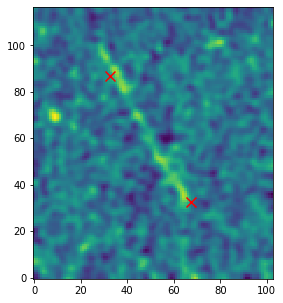

In [113]:
# Visualize frames one by one
frame = 9

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(stack[frame], interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(tip_start[1], tip_start[0], color='red', s=100, marker="x")

x, y = data.loc[frame, ['y', 'x']]
ax.scatter(x, y, color='red', s=100, marker="x")

#ax.text(0.75, 0.9, f"{data.loc[frame, 'time_s']:2.2f} s",
#        transform=ax.transAxes, color='#ffffff', fontsize=15)




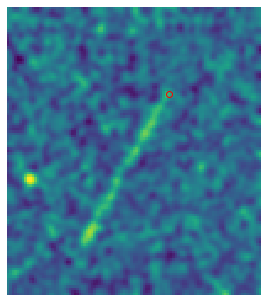

In [114]:
# Make a movie

movie_fps = 18  # frame/sec
image_size = 4
movie_dpi = 200

movie_start = frame_start
movie_end = frame_end

FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=movie_fps)

fig, ax = plt.subplots(figsize=(image_size, image_size))
mpl_im = ax.imshow(stack[movie_start], aspect='equal', interpolation='none')
mpl_tip = ax.scatter([], [], color='red',marker='o', facecolors='none')
mpl_text = ax.text(0.75, 0.9, "", transform=ax.transAxes, color='#ffffff', fontsize=34)

ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

#with writer.saving(fig, fname.with_suffix('.mp4'), movie_dpi):
with writer.saving(fig, 'movie.mp4', movie_dpi):
    for frame in range(movie_start, movie_end):
        mpl_im.set_data(stack[frame])
        mpl_tip.set_offsets(data.loc[frame, ['y', 'x']].values)
        #mpl_text.set_text(f"{data.loc[frame, 'time_s']:2.2f} s")
        writer.grab_frame()

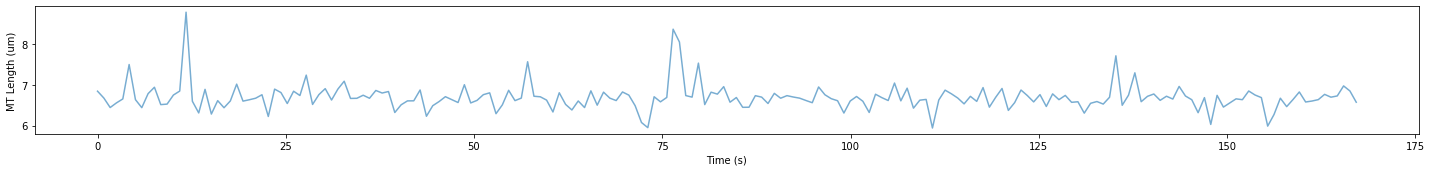

In [115]:
# Make a nice length versus time plot
# Length is calculated from a fixed reference located on the MT.

data['length_pixel'] = np.sqrt(((data.loc[:, ['x', 'y']] - tip_start) ** 2).sum(axis=1))
data['length_um'] = data['length_pixel'] * pixel_size / 1000
data['time_s'] = data['time'] / 1000

# if data.index.name == 'frame':
#     data = data.reset_index()
# data.to_csv(fname.with_suffix('.csv'), index=False)
# if data.index.name != 'frame':
#     data = data.set_index('frame')

fig, ax = plt.subplots(figsize=(20, 2.5))
#ax.scatter(data['time_s'], data['length_um'],marker='o',facecolor='',edgecolor='b',linewidth=1.5,s=60,alpha=0.4)
plt.plot(data['time_s'], data['length_um'],linewidth=1.5,alpha=0.6)

#ax.set_ylim(3.5, 7.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('MT Length (um)')
#plt.xlim(-1,470)
#plt.ylim(3,6.5)
plt.tight_layout()
fig.savefig(fname.with_suffix('.PLOT.jpg'))


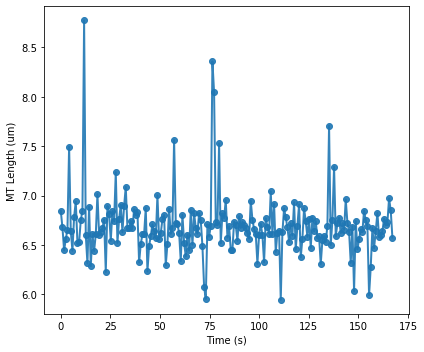

In [116]:
# Make a nice length versus time plot
# Length is calculated from a fixed reference located on the MT.

data['length_pixel'] = np.sqrt(((data.loc[:, ['x', 'y']] - tip_start) ** 2).sum(axis=1))
data['length_um'] = data['length_pixel'] * pixel_size / 1000
data['time_s'] = data['time'] / 1000

# if data.index.name == 'frame':
#     data = data.reset_index()
# data.to_csv(fname.with_suffix('.csv'), index=False)
# if data.index.name != 'frame':
#     data = data.set_index('frame')

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(data['time_s'], data['length_um'],marker='o',linewidth=2,alpha=0.9) #facecolor='',edgecolor='b',s=60,

#ax.set_ylim(3.5, 7.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('MT Length (um)')
#plt.xlim(155,205)
#plt.xlim(160,240)
#plt.ylim(3.6,3.9)
#plt.ylim(2.9,4.3)
plt.tight_layout()
ax.set_facecolor('w')
#fig.savefig(fname.with_suffix('.PLOT2.jpg'))


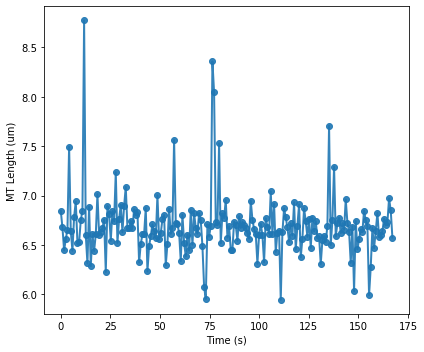

In [117]:
# Make a nice length versus time plot
# Length is calculated from a fixed reference located on the MT.

data['length_pixel'] = np.sqrt(((data.loc[:, ['x', 'y']] - tip_start) ** 2).sum(axis=1))
data['length_um'] = data['length_pixel'] * pixel_size / 1000
data['time_s'] = data['time'] / 1000

# if data.index.name == 'frame':
#     data = data.reset_index()
# data.to_csv(fname.with_suffix('.csv'), index=False)
# if data.index.name != 'frame':
#     data = data.set_index('frame')

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(data['time_s'], data['length_um'], marker='o',linewidth=2,alpha=0.9) #facecolor='',edgecolor='b',s=60,

#ax.set_ylim(3.5, 7.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('MT Length (um)')
#plt.xlim(155,205)
#plt.xlim(0,80)
#plt.ylim(3.6,3.9)
#plt.ylim(2.1,3.5)
plt.tight_layout()
ax.set_facecolor('w')
#fig.savefig(fname.with_suffix('.PLOT2.jpg'))


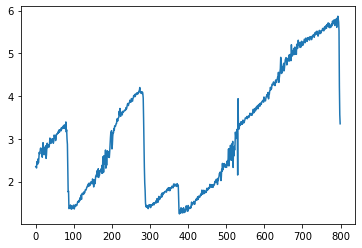

In [259]:
plt.plot(data['length_um'])

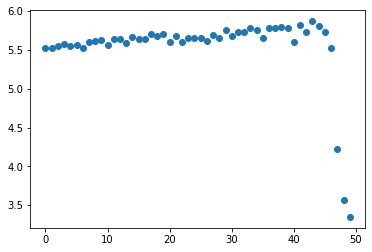

In [260]:
test1 = data['length_um'][750:800].to_list()
plt.scatter(np.arange(0,len(test1)), test1)

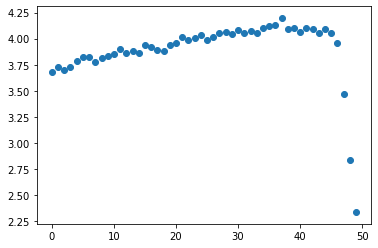

In [261]:
test2 = data['length_um'][236:286].to_list()
plt.scatter(np.arange(0,len(test2)), test2)

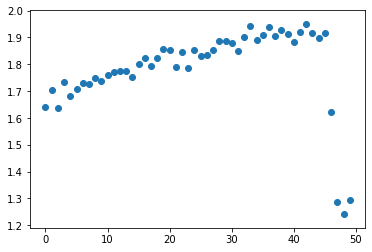

In [262]:
test3 = data['length_um'][329:379].to_list()
plt.scatter(np.arange(0,len(test3)), test3)

In [263]:
test1_2 = []
for i in test1:
    test1_2.append(i-test1[-4])
    
test2_2 = []
for i in test2:
    test2_2.append(i-test2[-4])

test3_2 = []
for i in test3:
    test3_2.append(i-test3[-4])

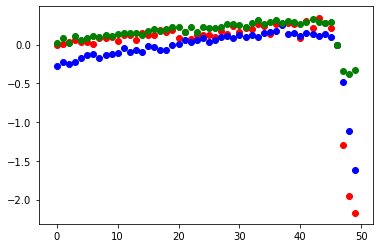

In [264]:
plt.scatter(np.arange(0,len(test1_2)), test1_2, color = 'r')
plt.scatter(np.arange(0,len(test2_2)), test2_2, color = 'b')
plt.scatter(np.arange(0,len(test3_2)), test3_2, color = 'g')

In [265]:
testavg = []
for i in np.arange(0,len(test1_2)):
    testavg.append((test1_2[i]+test2_2[i])/2)

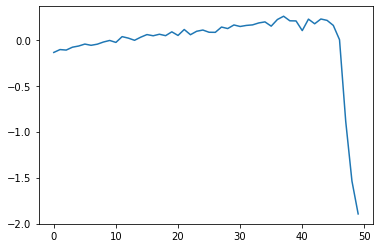

In [266]:
plt.plot(np.arange(0,len(testavg)),testavg)

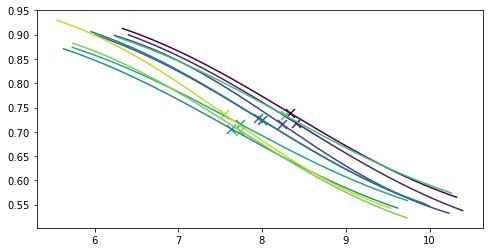

In [279]:


fig, ax = plt.subplots(figsize=(8, 4))

firstone = 410
lastone = 420
#lastone = 788

df = data.iloc[firstone:lastone]
i=0
for x_profile, y_profile, (_, row) in zip(x_profiles[firstone:lastone], y_profiles[firstone:lastone], df.iterrows()):
    
    pixlength = np.sqrt( (row['x']-data.loc[0, ['x']][0])**2 + (row['y']-data.loc[0, ['y']][0])**2 ) 
    
    args = row.to_dict()
    #args.pop('frame')
    args.pop('index')
    args.pop('time')
    args.pop('x')
    args.pop('y')
    args.pop('length_pixel')
    args.pop('length_um')
    args.pop('time_s')
    
    #x = np.arange(x_profile[0], x_profile[-2], 0.1)
    y_fitted = fit_func(row['mu'], **args)
    #y_fitted2 = fit_func(x, **args)

    #ax.plot(x_profile, y_profile)
    #ax.scatter(row['mu'], y_fitted, marker = 'x')
    #ax.plot(x, y_fitted2, alpha = 0.4)
    
    cmap = mpl.cm.viridis
    
    x = np.arange(pixlength-2,pixlength+2,0.01)
    args['mu'] = pixlength
    fitted_around = fit_func(x, **args)
    plt.plot(x, fitted_around, color=cmap(i / float(lastone-firstone)))

    ax.scatter(pixlength, y_fitted, marker = 'x', color=cmap(i / float(lastone-firstone)), s = 80)
    
    i+=1

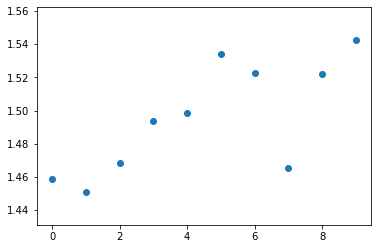

In [278]:
test1 = data['length_um'][410:420].to_list()
plt.scatter(np.arange(0,len(test1)), test1)

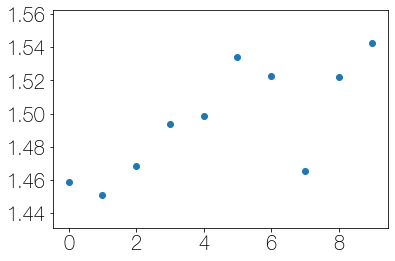

In [340]:
test1 = data['length_um'][410:420].to_list()
plt.rcParams['font.family'] ='Helvetica Neue Lt Std'
plt.scatter(np.arange(0,len(test1)), test1)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.show()